<style>
    .title_container {
        margin: auto;
        background: rgb(81,92,103);
        background: linear-gradient(90deg, rgba(81,92,103,1) 36%, rgba(12,35,66,1) 62%);
        border-radius: 7px;
        color: white;
        text-align:center;
        width:75%;
        padding-top:2%;
        padding-bottom:2%;
    }
    
    .question_container {
        margin: auto;
        background: rgb(84,138,142);
        background: linear-gradient(90deg, rgba(84,138,142,1) 41%, rgba(145,201,73,1) 81%);
        border-radius: 7px;
        color: white;
        text-align:left;
        width:75%;
        padding-top:1%;
        padding-bottom:1%;
        padding-left: 2%;
        margin-top:2%;
    }
    
    .question_container p {
        font-size: 16px;
    }
    
    .code_span {
        background-color: #E2E7EC;
        padding:2px;
        border-radius:1px;
        font-family: Consolas,monaco,monospace;
        color:black;
    }
</style>

<div class ='title_container'>
    <h1> Análisis de Datos II </h1>
    <h2> Profesor: Oldemar Rodríguez </h2>
    <h3> Estudiante: Jimmy Calvo Monge </h3>
    <h3> Carné: B31281 </h3>
    <hr style='color:white; width:80%;'>
    <h4> TAREA 5 </h4>
    <h4> Fecha de entrega: 25 de Setiembre de 2022 </h4>
</div>

Importamos los módulos necesarios para resolver esta tarea.

In [46]:
### Basicos
import numpy as np
import pandas as pd
from pandas import DataFrame

### Utilidades/Varios
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from sklearn.tree import export_graphviz
from sklearn import tree
import seaborn as sns
import time
import graphviz

### Training/Testing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### predictPy
from predictPy import Analisis_Predictivo

### Modelos:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [42]:
def indices_general(MC, nombres = None):
    precision_global = np.sum(MC.diagonal()) / np.sum(MC)
    error_global     = 1 - precision_global
    precision_categoria  = pd.DataFrame(MC.diagonal()/np.sum(MC,axis = 1)).T
    if nombres!=None:
        precision_categoria.columns = nombres
    return {"Matriz de Confusión":MC, 
            "Precisión Global":   precision_global, 
            "Error Global":       error_global, 
            "Precisión por categoría":precision_categoria}

### Clase MatConf de la Tarea 2

class MatConf:
    
    def __init__(self,matriz):
        
        self.mat_conf = matriz
        
        VN = self.mat_conf[0,0]
        VP = self.mat_conf[1,1]
        FP = self.mat_conf[0,1]
        FN = self.mat_conf[1,0]
        
        dict_medidas = {
            'Precisión Global' : (VN+VP)/(VN+FP+FN+VP),
            'Error Global' : (FN+FP)/(VN+FP+FN+VP),
            'Precisión Positiva (PP)' : VP/(FN+VP),
            'Precisión Negativa (PN)' : VN/(VN+FP),
            'Proporción de Falsos Positivos (PFP)' : FP/(VN+FP),
            'Proporción de Falsos Negativos (PFN)' : FN/(FN+VP),
            'Asertividad Positiva (AP)' : VP/(FP+VP),
            'Asertividad Negativa (AN)' : VN/(VN+FN)
        }
        self.dict_medidas = dict_medidas
        
    def __str__(self):
        mensaje="Estos son los resultados para esta matriz de confusion:"
        for key in list(self.dict_medidas.keys()):
            mensaje = mensaje + f"\n - {key}: {self.dict_medidas[key]}"
        return mensaje

<div class='question_container'>
    <h2> Pregunta 1 </h2>
    <p> En este ejercicio vamos a usar la tabla de datos <span class='code_span'>raisin.csv</span>, que contiene el resultado de un sistema de visión artificial para distinguir entre dos variedades diferentes de pasas (Kecimen y Besni) cultivadas en Turquía. Estas imágenes se sometieron a varios pasos de preprocesamiento y se realizaron 7 operaciones de extracción de características morfológicas utilizando técnicas de procesamiento de imágenes. </p>
    <p>El conjunto de datos tiene 900 filas y 8 columnas las cuales se explican a continuación:</p>
    <ul>
        <li><span class='code_span'>Area</span> El número de píxeles dentro de los límites de la pasa. </li>
        <li><span class='code_span'>MajorAxisLength</span> La longitud del eje principal, que es la línea más larga que se puede dibujar en la pasa. </li>
        <li><span class='code_span'>MinorAxisLength</span> La longitud del eje pequeño, que es la línea más corta que se puededibujar en la pasa. </li>
        <li><span class='code_span'>Eccentricity</span> Una medida de la excentricidad de la elipse, que tiene los mismos momentos que las pasas. </li>
        <li><span class='code_span'>ConvexArea</span> El número de píxeles de la capa convexa más pequeña de la región formada por la pasa. </li>
        <li><span class='code_span'>Extent</span> La proporción de la región formada por la pasa al total de píxeles en el cuadro delimitador. </li>
        <li><span class='code_span'>Perimeter</span> Mide el entorno calculando la distancia entre los límites de la pasa y los píxeles que la rodean. </li>
        <li><span class='code_span'>Class</span> Tipo de pasa Kecimen y Besni (Variable a predecir). </li>
    </ul>
    <p> Realice lo siguiente: </p>
    <ol>
        <li> Use Bosques Aleatorios, ADABoosting y XGBoosting en Python para generar un modelo predictivo para la tabla raisin.csv usando el 75% de los datos para la tabla aprendizaje y un 25% para la tabla testing. Use la configuración de parámetros que usted mejor considere o identifique.</li>
        <li> Según los gráficos de importancia de variables, indique cuáles son las 4 variables más importantes para los modelos. </li>
        <li> Construya un <span class='code_span'>DataFrame</span> que compare los modelos construidos arriba con los mejores modelos construidos en tareas anteriores para la tabla <span class='code_span'>raisin.csv</span>. Para esto en cada una de las filas debe aparecer un modelo predictivo y en las columnas aparezcan los índices Precisión Global, Error Global, Precisión Positiva (PP) y Precisión Negativa (PN). ¿Cuál de los modelos es mejor para estos datos? Guarde los datos de este DataFrame, ya que se irá modificando en próximas tareas.</li>
    </ol>
</div>

In [189]:
### Leer datos
df_raisin = pd.read_csv('raisin.csv')
### Training-Testing

# Variable a predecir
y = df_raisin["Class"].ravel()

#Convertimos a Dummy algunas de las variables predictoras
df_raisin_num = df_raisin.drop(['Class'],axis=1)
X = df_raisin_num

#Partimos los datos en training-testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

Para identificar los mejores hiperparámetros a utilizar en cada modelo vamos a realizar una malla de hiperparámetros. En el caso de bosques aleatorios vamos a variar el número de árboles. Seleccionaremos el modelo con mejor precisión global.

In [217]:
df_bosques=pd.DataFrame({})

n_arboles=list(range(10,200,5))
min_sample_splits=list(range(5,50,5))

start=time.time()
for n in n_arboles:
    for m in min_sample_splits:
        instancia_bosques = RandomForestClassifier(n_estimators = n, criterion = "gini", min_samples_split = m)
        instancia_bosques.fit(X_train.values,y_train)
        prediccion_bosques = instancia_bosques.predict(X_test.values)
        MC_bosques = confusion_matrix(y_test, prediccion_bosques, labels=list(np.unique(y_train)))
        medidas_este_bosque=MatConf(MC_bosques).dict_medidas
        df_este_bosque=pd.DataFrame({'n_arboles':[n], 'min_samples_split':[m]})
        for key in list(medidas_este_bosque.keys()):
            df_este_bosque[key]=[medidas_este_bosque[key]]
        df_bosques= df_bosques.append(df_este_bosque,ignore_index=True)
end=time.time()
print(f"Esta búsqueda de hiperparámetros para bosques aleatorios tomó {end-start} segundos.")

Esta búsqueda de hiperparámetros para bosques aleatorios tomó 63.78954887390137 segundos.


In [218]:
df_bosques=df_bosques.sort_values(by=['Precisión Global'],ascending=False)
df_bosques.head(1)

,n_arboles,min_samples_split,Precisión Global,Error Global,Precisión Positiva (PP),Precisión Negativa (PN),Proporción de Falsos Positivos (PFP),Proporción de Falsos Negativos (PFN),Asertividad Positiva (AP),Asertividad Negativa (AN)
37,30,10,0.866667,0.133333,0.957265,0.768519,0.231481,0.042735,0.817518,0.943182


El mejor modelo de árboles de decisión que obtuvimos fue usando 30 árboles y un mínimos de variables en splits en cada árbol de 10 variables. Hacemos lo mismo para los otros dos tipos de modelos.

In [225]:
df_ada=pd.DataFrame({})

# Instancia Árboles de decisión
instancia_tree = DecisionTreeClassifier(criterion="gini")
n_est=list(range(10,200,5))

start=time.time()
for n in n_est:
    instancia_ada = AdaBoostClassifier(base_estimator=instancia_tree,n_estimators=n)
    instancia_ada.fit(X_train.values,y_train)
    prediccion_ada = instancia_ada.predict(X_test.values)
    MC_ada = confusion_matrix(y_test, prediccion_ada, labels=list(np.unique(y_train)))
    medidas_este_ada=MatConf(MC_ada).dict_medidas
    df_este_ada=pd.DataFrame({'n_estimadores':[n]})
    for key in list(medidas_este_ada.keys()):
        df_este_ada[key]=[medidas_este_ada[key]]
    df_ada= df_ada.append(df_este_ada,ignore_index=True)
    
end=time.time()
print(f"Esta búsqueda de hiperparámetros para ADA Boost's tomó {end-start} segundos.")

Esta búsqueda de hiperparámetros para ADA Boost's tomó 0.3521878719329834 segundos.


In [226]:
df_ada=df_ada.sort_values(by=['Precisión Global'],ascending=False)
df_ada.head(1)

,n_estimadores,Precisión Global,Error Global,Precisión Positiva (PP),Precisión Negativa (PN),Proporción de Falsos Positivos (PFP),Proporción de Falsos Negativos (PFN),Asertividad Positiva (AP),Asertividad Negativa (AN)
37,195,0.84,0.16,0.888889,0.787037,0.212963,0.111111,0.818898,0.867347


El mejor modelo de árboles de ADA Boost fue utilizando 145 estimadores.

In [227]:
df_xgb=pd.DataFrame({})

n_est=list(range(10,200,5))
min_sample_splits=list(range(5,50,5))

start=time.time()
for n in n_est:
    for m in min_sample_splits:
        instancia_xgb = GradientBoostingClassifier(n_estimators=n, min_samples_split=m)
        instancia_xgb.fit(X_train.values,y_train)
        prediccion_xgb = instancia_xgb.predict(X_test.values)
        MC_xgb = confusion_matrix(y_test, prediccion_xgb, labels=list(np.unique(y_train)))
        medidas_este_xgb=MatConf(MC_xgb).dict_medidas
        df_este_xgb=pd.DataFrame({'n_estimadores':[n], 'min_samples_split':[m]})
        for key in list(medidas_este_xgb.keys()):
            df_este_xgb[key]=[medidas_este_xgb[key]]
        df_xgb= df_xgb.append(df_este_xgb,ignore_index=True)
    
end=time.time()
print(f"Esta búsqueda de hiperparámetros para XG Boost's tomó {end-start} segundos.")

Esta búsqueda de hiperparámetros para XG Boost's tomó 56.97447919845581 segundos.


In [228]:
df_xgb=df_xgb.sort_values(by=['Precisión Global'],ascending=False)
df_xgb.head(1)

,n_estimadores,min_samples_split,Precisión Global,Error Global,Precisión Positiva (PP),Precisión Negativa (PN),Proporción de Falsos Positivos (PFP),Proporción de Falsos Negativos (PFN),Asertividad Positiva (AP),Asertividad Negativa (AN)
83,55,15,0.888889,0.111111,0.948718,0.824074,0.175926,0.051282,0.853846,0.936842


Comparemos los tres modelos anteriores en un solo DataFrame

In [233]:
df_comparacion_p1=df_bosques.head(1).drop(['n_arboles','min_samples_split'],axis=1)
df_comparacion_p1=df_comparacion_p1.append(df_ada.head(1).drop(['n_estimadores'],axis=1),ignore_index=True)
df_comparacion_p1=df_comparacion_p1.append(df_xgb.head(1).drop(['n_estimadores','min_samples_split'],axis=1),ignore_index=True)
df_comparacion_p1.index=['Bosque Aleatorio','ADA Boost','XG Boost']
df_comparacion_p1

,Precisión Global,Error Global,Precisión Positiva (PP),Precisión Negativa (PN),Proporción de Falsos Positivos (PFP),Proporción de Falsos Negativos (PFN),Asertividad Positiva (AP),Asertividad Negativa (AN)
Bosque Aleatorio,0.866667,0.133333,0.957265,0.768519,0.231481,0.042735,0.817518,0.943182
ADA Boost,0.840000,0.160000,0.888889,0.787037,0.212963,0.111111,0.818898,0.867347
XG Boost,0.888889,0.111111,0.948718,0.824074,0.175926,0.051282,0.853846,0.936842


En la tarea pasada teníamos los siguientes resultados:

In [237]:
comparacion_T4=pd.DataFrame({
    'Precisión Global': [0.875556,0.861111],
    'Error Global':[0.124444,0.138889],
    'Precisión Positiva (PP)':[0.842975,0.908163],
    'Precisión Negativa (PN)':[0.913462,0.804878],
    'Proporción de Falsos Positivos (PFP)':[0.086538,0.195122],
    'Proporción de Falsos Negativos (PFN)':[0.157025,0.091837],
    'Asertividad Positiva (AP)':[0.918919,0.847619],
    'Asertividad Negativa (AN)':[0.833333,0.880000]
})
comparacion_T4.index=['KNN','Árbol Decisión']
print("Los resultados finales de todos los modelos fueron: ")
comparacion_T4.append(df_comparacion_p1)

Los resultados finales de todos los modelos fueron: 


,Precisión Global,Error Global,Precisión Positiva (PP),Precisión Negativa (PN),Proporción de Falsos Positivos (PFP),Proporción de Falsos Negativos (PFN),Asertividad Positiva (AP),Asertividad Negativa (AN)
KNN,0.875556,0.124444,0.842975,0.913462,0.086538,0.157025,0.918919,0.833333
Árbol Decisión,0.861111,0.138889,0.908163,0.804878,0.195122,0.091837,0.847619,0.880000
Bosque Aleatorio,0.866667,0.133333,0.957265,0.768519,0.231481,0.042735,0.817518,0.943182
ADA Boost,0.840000,0.160000,0.888889,0.787037,0.212963,0.111111,0.818898,0.867347
XG Boost,0.888889,0.111111,0.948718,0.824074,0.175926,0.051282,0.853846,0.936842


En términos de precisión global el modelo de `XG Boost` se comportó de manera superior, sin embargo `KNN` nos da una mayor precisión negativa. Parece que `ADA Boost` es el que tiene el peor desempeño sobre estos datos.

Finalmente, realizamos un gráfico de importancia de variables para cada uno de los tres modelos de este ejercicio. Note que he fijado el training testing en los tres para tener mejor control sobre la posible variación de los gráficos.

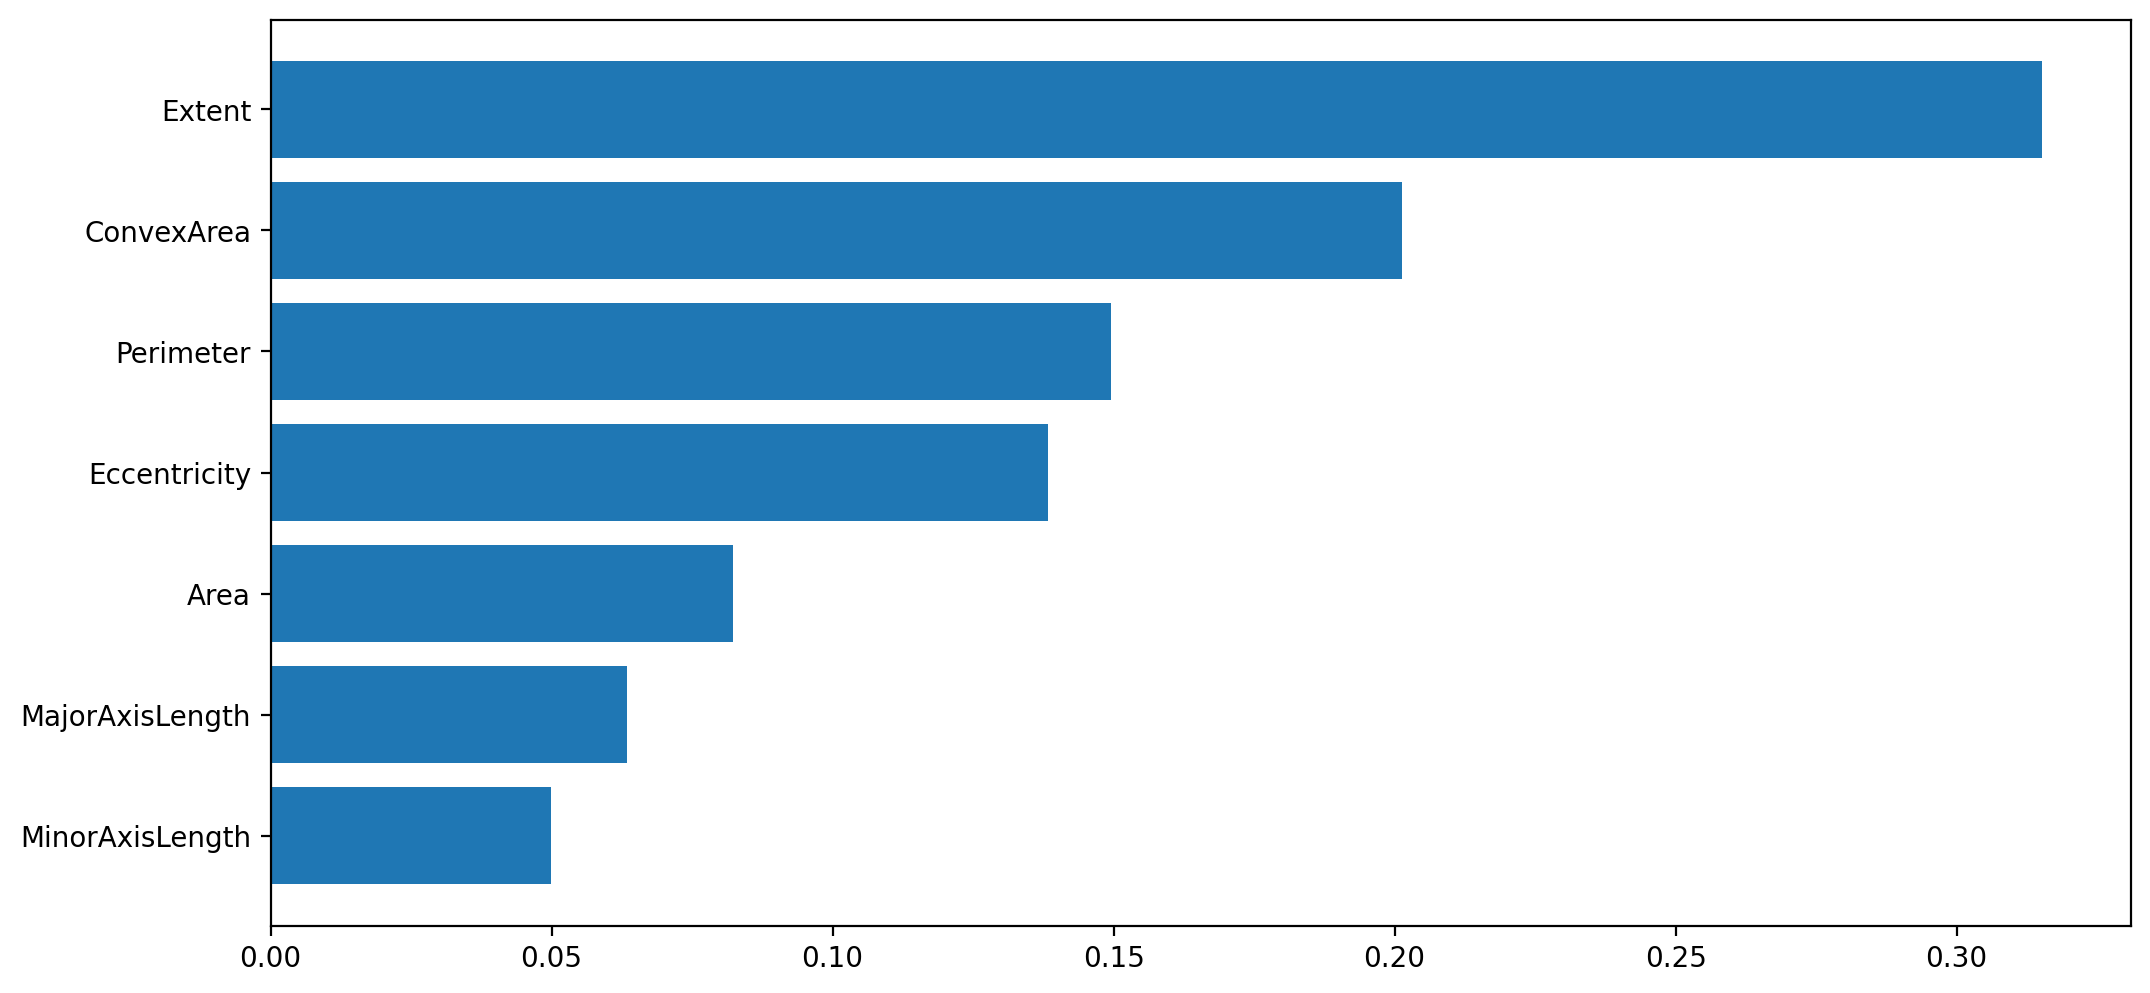

In [265]:
### Para Bosques Aleatorios ###
etiquetas=np.array(['Eccentricity', 'Extent', 'MinorAxisLength', 'Area', 'ConvexArea', 'MajorAxisLength', 'Perimeter'])

instancia_bosques = RandomForestClassifier(n_estimators = 30, criterion = "gini", min_samples_split = 10)
instancia_bosques.fit(X_train.values,y_train)
importancia_bosques = np.array(instancia_bosques.feature_importances_)

orden = np.argsort(importancia_bosques)
importancia_bosques = importancia_bosques[orden]
etiquetas = etiquetas[orden]

fig, ax = plt.subplots(1,1, figsize = (12,6), dpi = 200)
ax.barh(etiquetas, importancia_bosques)
plt.show()

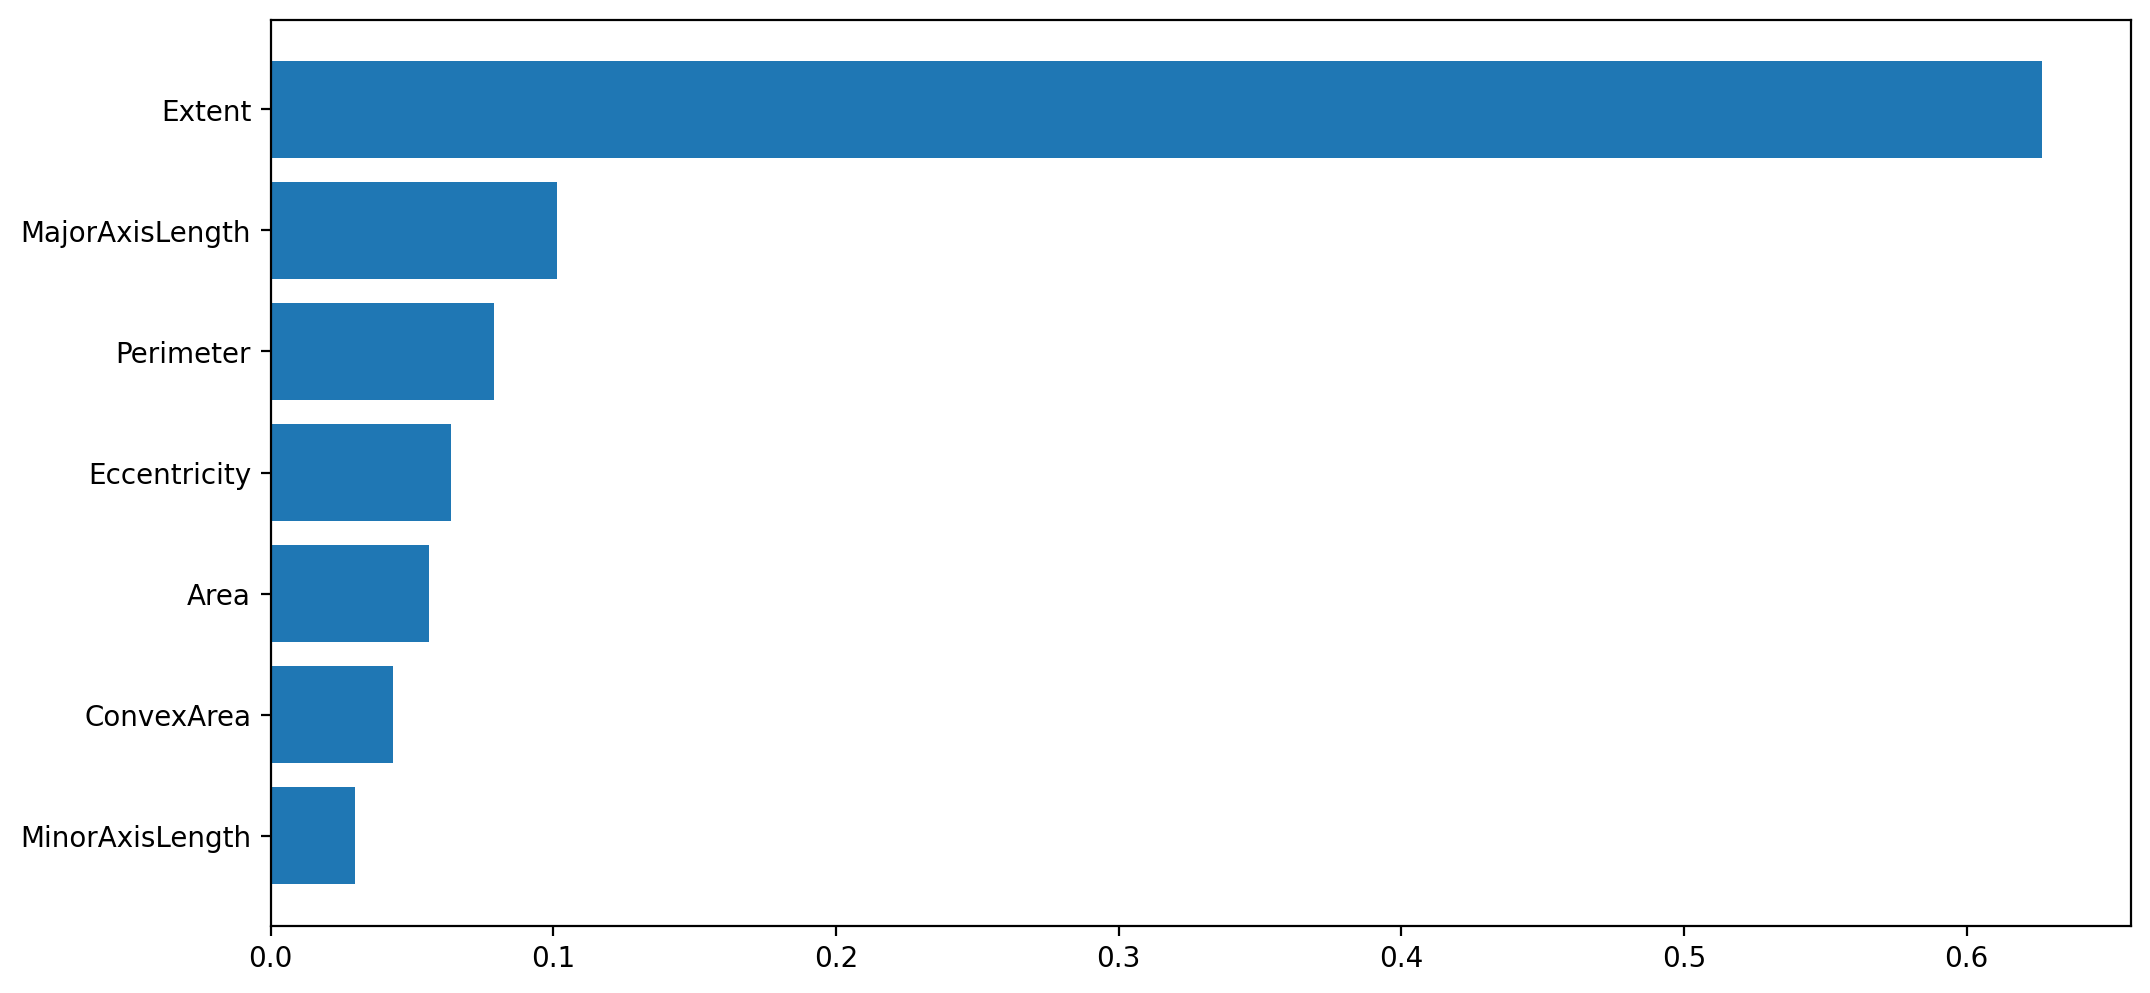

In [266]:
### Para ADA Boost ###
etiquetas=np.array(['Eccentricity', 'Extent', 'MinorAxisLength', 'Area', 'ConvexArea', 'MajorAxisLength', 'Perimeter'])

instancia_tree = DecisionTreeClassifier(criterion="gini")
instancia_ada = AdaBoostClassifier(base_estimator=instancia_tree,n_estimators=195)
instancia_ada.fit(X_train.values,y_train)
importancia_ada = np.array(instancia_ada.feature_importances_)

orden = np.argsort(importancia_ada)
importancia_ada = importancia_ada[orden]
etiquetas = etiquetas[orden]

fig, ax = plt.subplots(1,1, figsize = (12,6), dpi = 200)
ax.barh(etiquetas, importancia_ada)
plt.show()

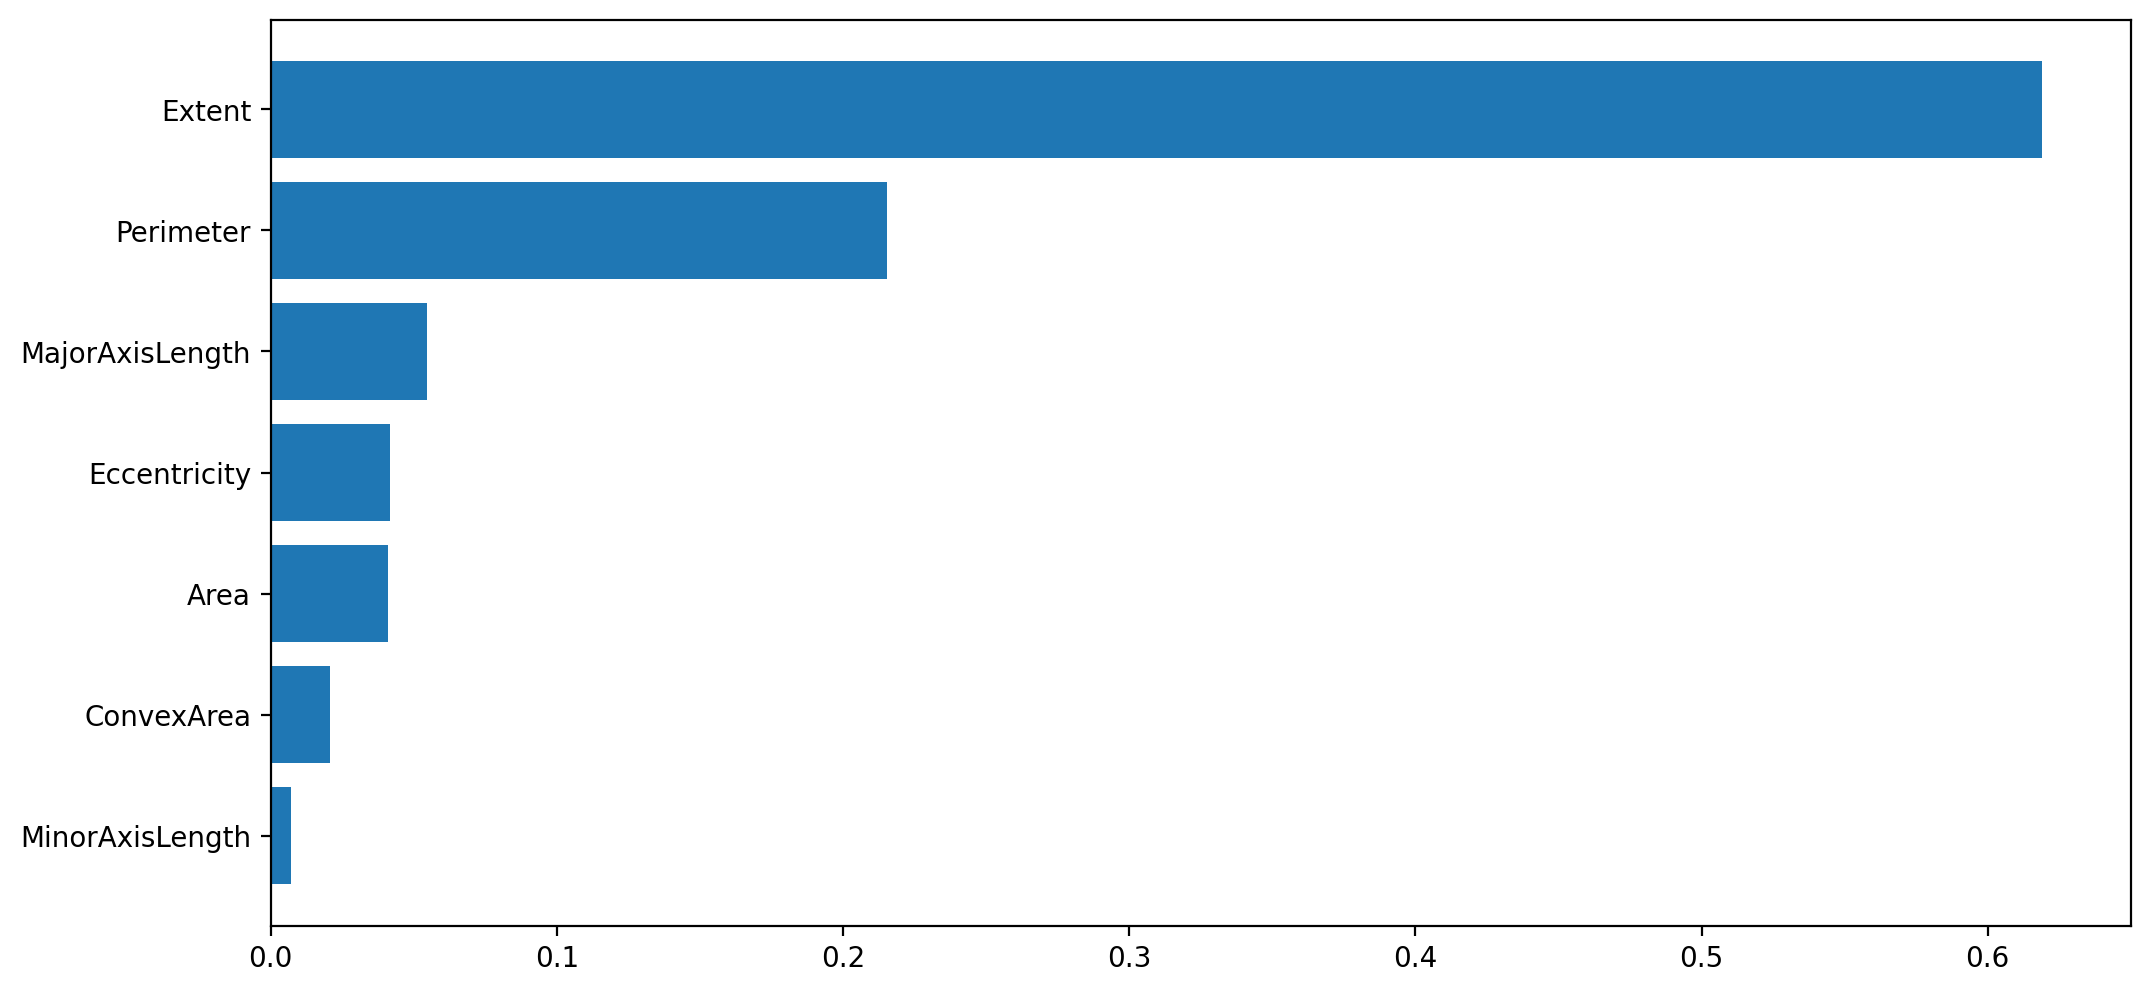

In [267]:
### Para XG Boost ###
etiquetas=np.array(['Eccentricity', 'Extent', 'MinorAxisLength', 'Area', 'ConvexArea', 'MajorAxisLength', 'Perimeter'])

instancia_xgb = GradientBoostingClassifier(n_estimators=55, min_samples_split=15)
instancia_xgb.fit(X_train.values,y_train)
importancia_xgb = np.array(instancia_xgb.feature_importances_)

orden = np.argsort(importancia_xgb)
importancia_xgb = importancia_xgb[orden]
etiquetas = etiquetas[orden]

fig, ax = plt.subplots(1,1, figsize = (12,6), dpi = 200)
ax.barh(etiquetas, importancia_xgb)
plt.show()

**Observaciones:**

- Logramos ver que la importancia de las variables es similar entre `XGBoost` y `ADABoost` para este conjunto de datos y este training-testing split en particular. Observamos que las variables más importantes para estos dos modelos son `Extent`,`Perimeter`,`MajorAxisLength` y `Eccentricity`. Para Bosques Aleatorios se da una situación diferente, en la que predominan `Perimeter`,`Extent`,`ConvexArea` y `Area`. Tanto en `XGBoost` como en `ADABoost` la variable `Extent` tiene una importancia mucho mayor que las demás. Vea que en Bosques Aleatorios no hay alguna variable con tanta importancia.

<div class='question_container'>
    <h2> Pregunta 2 </h2>
    <p> En este ejercicio usaremos la tabla de datos <code>abandono_clientes.csv</code>, que contiene los detalles de los clientes de un banco. </p>
    <p> La tabla contiene 11 columnas (variables), las cuales se explican a continuación. </p>
    <ul>
        <li> <span class='code_span'> CreditScore </span>: Indica el puntaje de crédito. </li>
        <li> <span class='code_span'>Geography</span>: País al que pertenece.</li>
        <li> <span class='code_span'>Gender</span>: Género del empleado.</li>
        <li> <span class='code_span'>Age</span>: Edad del empleado.</li>
        <li> <span class='code_span'>Tenure</span>: El tiempo del vínculo con la empresa.</li>
        <li> <span class='code_span'>Balance</span>: La cantidad que les queda.</li>
        <li> <span class='code_span'>NumOfProducts</span>: Los productos que posee.</li>
        <li> <span class='code_span'>HasCrCard</span>: Tienen tarjeta de crédito o no.</li>
        <li> <span class='code_span'>IsActiveMember</span>: Es un miembro activo o no.</li>
        <li> <span class='code_span'>EstimatedSalary</span>: Salario estimado.</li>
        <li> <span class='code_span'>Exited</span>: Indica si el cliente se queda o se va.</li>
    </ul>
    <p> Realice lo siguiente: </p>
    <ol>
        <li> Cargue en <span class='code_span'>Python</span> la tabla de datos <span class='code_span'>abandono_clientes.csv</span>. </li>
        <li> Use Bosques Aleatorios, ADABoosting y XGBoosting en Python para generar modelos predictivos para la tabla datos abandono clientes.csv usando el 75% de los datos para la tabla aprendizaje y un 25% para la tabla testing. Use la configuración de parámetros que usted mejor considere o identifique. Luego calcule para los datos de testing la matriz de confusión, la precisión global y la precisión para cada una de las dos categorías. ¿Son buenos los resultados? Explique. </li>
        <li> Repita el ítem anterior, pero esta vez seleccione 6 variables predictoras. Para esto utilice el gráfico de importancia de variables del método Bosques Aleatorios. ¿Mejora la predicción?. </li>
        <li> Construya un <span class='code_span'>DataFrame</span> que compare los mejores modelos construidos arriba con los mejores modelos generados en tareas anteriores para la tabla <span class='code_span'>abandono_clientes.csv</span>. Para esto en cada una de las filas debe aparecer un modelo predictivo y en las columnas aparezcan los índices Precisión Global, Error Global, Precisión Positiva (PP) y Precisión Negativa (PN). ¿Cuál de los modelos es mejor para estos datos? Guarde los datos de este DataFrame, ya que se irá modificando en próximas tareas. </li>
    </ol>
</div>

In [310]:
# Leemos los datos

df_clientes = pd.read_csv("abandono_clientes.csv")
df_clientes = df_clientes.drop(['Unnamed: 0'], axis=1)

# Convierte las variables a categórica
columnas_cat= [col for col in df_clientes.columns if str(df_clientes.dtypes[col]) =='object' and col!='Exited' ] ### Columnas predictivas y string
for col in columnas_cat:
    df_clientes[col] = df_clientes[col].astype('category')
    
# Variable a predecir
y = df_clientes["Exited"].ravel()

#Convertimos a Dummy algunas de las variables predictoras
X = pd.get_dummies(df_clientes.drop(columns=["Exited"]), columns=columnas_cat)

X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_No,HasCrCard_Si,IsActiveMember_No,IsActiveMember_Si
0,619,42,2,0.00,1,101348.88,1,0,0,1,0,0,1,0,1
1,608,41,1,83807.86,1,112542.58,0,0,1,1,0,1,0,0,1
2,502,42,8,159660.80,3,113931.57,1,0,0,1,0,0,1,1,0
3,699,39,1,0.00,2,93826.63,1,0,0,1,0,1,0,1,0
4,850,43,2,125510.82,1,79084.10,0,0,1,1,0,0,1,0,1


In [311]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [312]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_No,HasCrCard_Si,IsActiveMember_No,IsActiveMember_Si
901,684,29,8,127269.75,1,79495.01,0,1,0,0,1,1,0,0,1
3205,827,35,0,0.00,2,184514.01,0,0,1,1,0,1,0,0,1
1665,643,31,3,167949.48,1,143162.34,1,0,0,1,0,0,1,1,0
421,599,39,4,0.00,1,194273.20,0,0,1,1,0,0,1,1,0
2325,671,51,3,96891.46,1,176403.33,0,1,0,0,1,0,1,1,0


Hacemos lo mismo que en la pregunta anterior, para determinar los mejores hiperparámetros para cada modelo

In [313]:
df_bosques=pd.DataFrame({})

n_arboles=list(range(10,200,5))
min_sample_splits=list(range(5,25,5))

start=time.time()
for n in n_arboles:
    for m in min_sample_splits:
        instancia_bosques = RandomForestClassifier(n_estimators = n, criterion = "gini", min_samples_split = m)
        instancia_bosques.fit(X_train.values,y_train)
        prediccion_bosques = instancia_bosques.predict(X_test.values)
        MC_bosques = confusion_matrix(y_test, prediccion_bosques, labels=list(np.unique(y_train)))
        medidas_este_bosque=MatConf(MC_bosques).dict_medidas
        df_este_bosque=pd.DataFrame({'n_arboles':[n], 'min_samples_split':[m]})
        for key in list(medidas_este_bosque.keys()):
            df_este_bosque[key]=[medidas_este_bosque[key]]
        df_bosques= df_bosques.append(df_este_bosque,ignore_index=True)
end=time.time()
print(f"Esta búsqueda de hiperparámetros para bosques aleatorios tomó {end-start} segundos.")

Esta búsqueda de hiperparámetros para bosques aleatorios tomó 134.47562265396118 segundos.


In [314]:
df_bosques=df_bosques.sort_values(by=['Precisión Global'],ascending=False)
df_bosques.head(1)

,n_arboles,min_samples_split,Precisión Global,Error Global,Precisión Positiva (PP),Precisión Negativa (PN),Proporción de Falsos Positivos (PFP),Proporción de Falsos Negativos (PFN),Asertividad Positiva (AP),Asertividad Negativa (AN)
21,35,10,0.855598,0.144402,0.423664,0.96515,0.03485,0.576336,0.755102,0.868467


El mejor modelo de Bosques Aleatorios para estos datos se obtuvo con $35$ árboles con un mínimo de $10$ variables en cada split. Veamos la matriz de confusión para este modelo:

In [315]:
instancia_bosques = RandomForestClassifier(n_estimators = 55, criterion = "gini", min_samples_split = 15)
instancia_bosques.fit(X_train.values,y_train)
prediccion_bosques = instancia_bosques.predict(X_test.values)
MC_bosques = confusion_matrix(y_test, prediccion_bosques, labels=list(np.unique(y_train))) ### Puede variar un poco con respecto al resultado anterior.
MC_bosques

array([[1003,   30],
       [ 161,  101]], dtype=int64)

Vea que nuestra precisión global es de 0.85, pero la precisión positiva es de 0.42. Claramente en la clase Negativa la predicción es mucho mejor, pero esto se debe al desbalance de las clases, que ya hemos visto en este conjunto de datos.

Antes de seguir con los otros modelos, vamos a ajustar un modelo de Bosques Aleatorios pero utilizando una selección de variables predictoras. El enunciado de la tarea no especifica cómo seleccionarlas así que, para variar, voy a seleccionar las variables más importantes del modelo anterior. (En la tarea pasada hicimos esto viendo los gráficos de poder predictivo, pero usar los bosques aleatorios es otra opción para hacer selección de variables también)

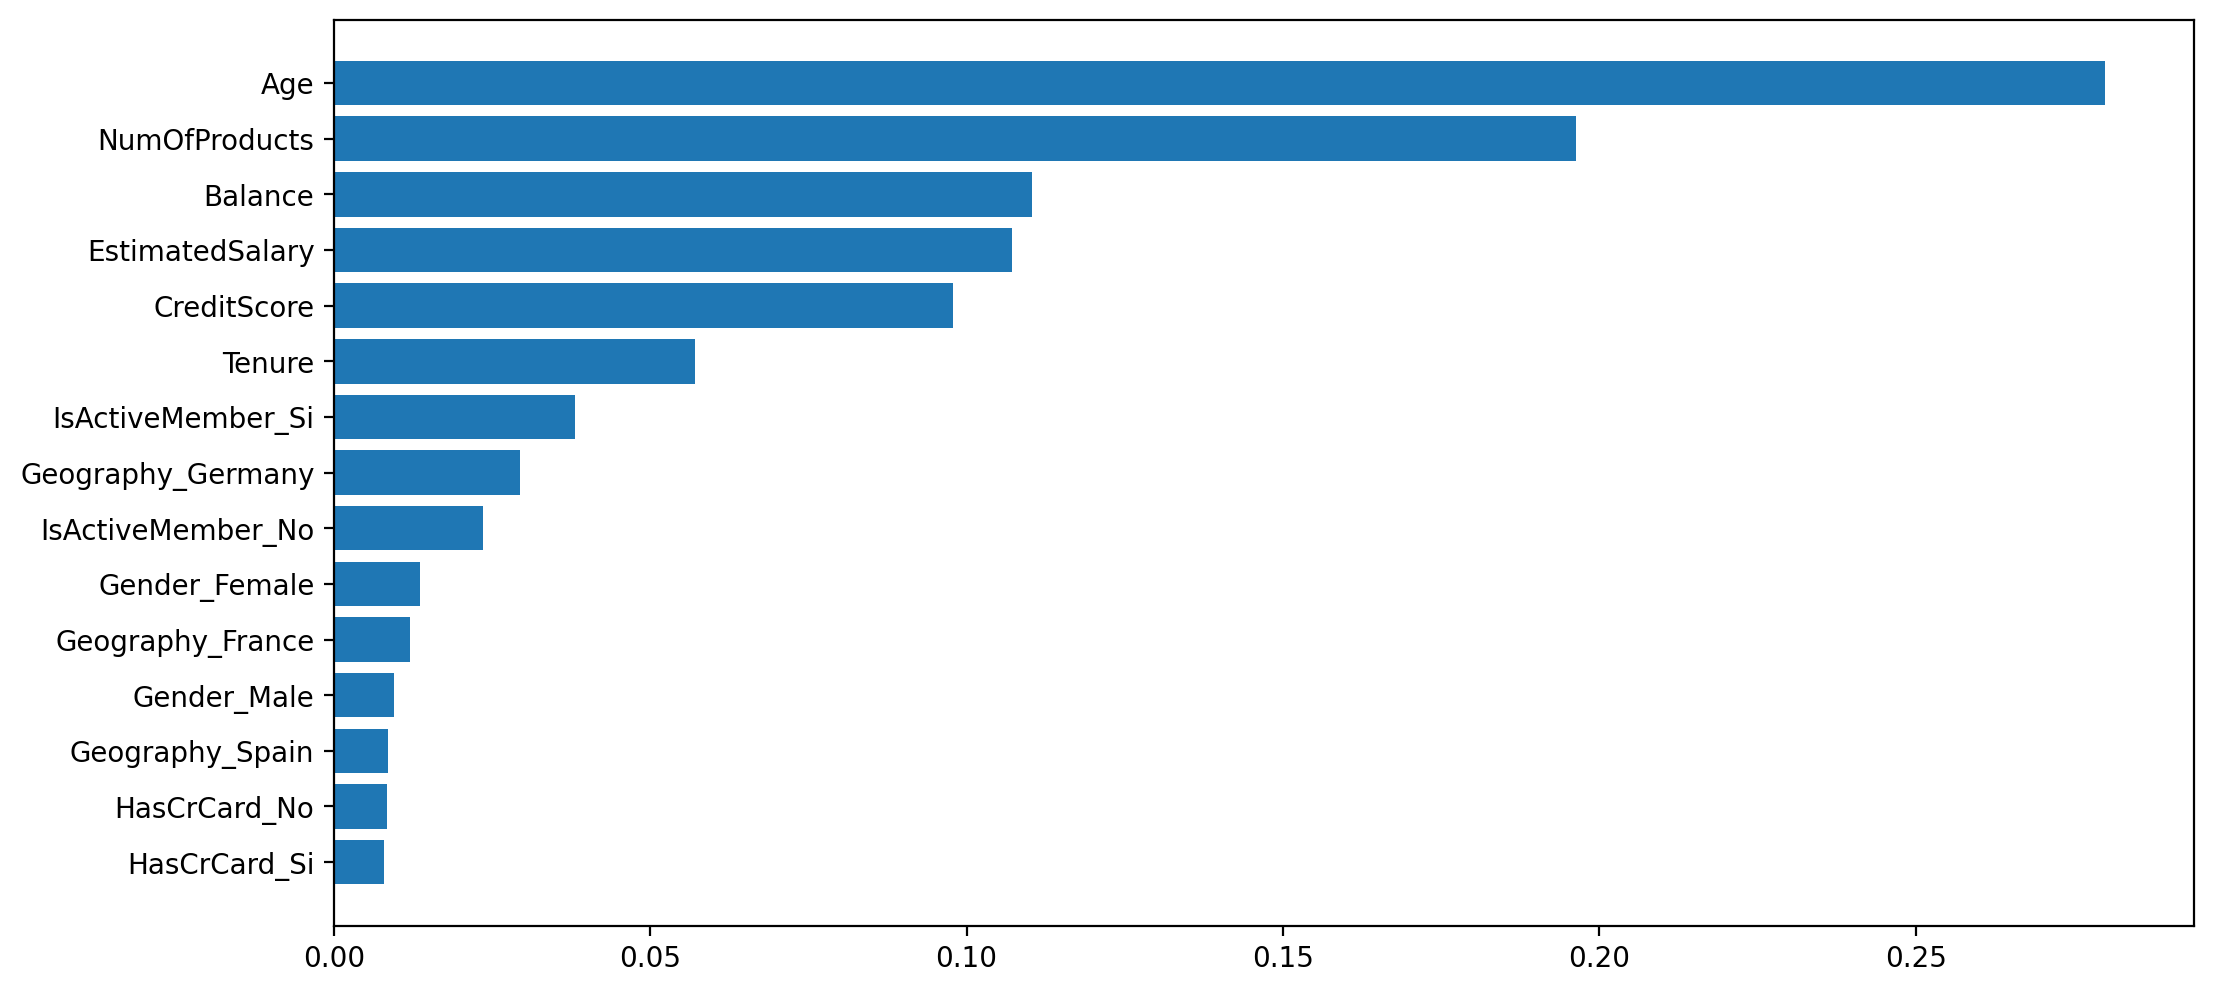

In [316]:
etiquetas=np.array(X_train.columns.tolist())
importancia_bosques = np.array(instancia_bosques.feature_importances_)
orden = np.argsort(importancia_bosques)
importancia_bosques = importancia_bosques[orden]
etiquetas = etiquetas[orden]
fig, ax = plt.subplots(1,1, figsize = (12,6), dpi = 200)
ax.barh(etiquetas, importancia_bosques)
plt.show()

Seleccionamos entonces las siguientes variables.

In [332]:
vars_select=['Age','NumOfProducts','Balance','CreditScore','EstimatedSalary','Tenure']

X_train_6=X_train[vars_select]
X_test_6=X_test[vars_select]

### Volvemos a realizar la búsqueda de hiperparámetros:

df_bosques_6=pd.DataFrame({})

n_arboles=list(range(10,200,5))
min_sample_splits=list(range(5,25,5))

start=time.time()
for n in n_arboles:
    for m in min_sample_splits:
        instancia_bosques = RandomForestClassifier(n_estimators = n, criterion = "gini", min_samples_split = m)
        instancia_bosques.fit(X_train_6.values,y_train)
        prediccion_bosques = instancia_bosques.predict(X_test_6.values)
        MC_bosques = confusion_matrix(y_test, prediccion_bosques, labels=list(np.unique(y_train)))
        medidas_este_bosque=MatConf(MC_bosques).dict_medidas
        df_este_bosque=pd.DataFrame({'n_arboles':[n], 'min_samples_split':[m]})
        for key in list(medidas_este_bosque.keys()):
            df_este_bosque[key]=[medidas_este_bosque[key]]
        df_bosques_6= df_bosques_6.append(df_este_bosque,ignore_index=True)
end=time.time()
print(f"Esta búsqueda de hiperparámetros para bosques aleatorios tomó {end-start} segundos.")

Esta búsqueda de hiperparámetros para bosques aleatorios tomó 161.82599306106567 segundos.


In [334]:
df_bosques_6=df_bosques_6.sort_values(by=['Precisión Global'],ascending=False)
df_bosques_6.head(1)

,n_arboles,min_samples_split,Precisión Global,Error Global,Precisión Positiva (PP),Precisión Negativa (PN),Proporción de Falsos Positivos (PFP),Proporción de Falsos Negativos (PFN),Asertividad Positiva (AP),Asertividad Negativa (AN)
136,180,5,0.835521,0.164479,0.343511,0.96031,0.03969,0.656489,0.687023,0.852234


Reduciendo a 6 variables no mejoró significativamente el modelo.

Procedemos a hacer lo mismo con `ADA Boost`.

In [277]:
df_ada=pd.DataFrame({})

# Instancia Árboles de decisión
instancia_tree = DecisionTreeClassifier(criterion="gini")
n_est=list(range(10,200,5))

start=time.time()
for n in n_est:
    instancia_ada = AdaBoostClassifier(base_estimator=instancia_tree,n_estimators=n)
    instancia_ada.fit(X_train.values,y_train)
    prediccion_ada = instancia_ada.predict(X_test.values)
    MC_ada = confusion_matrix(y_test, prediccion_ada, labels=list(np.unique(y_train)))
    medidas_este_ada=MatConf(MC_ada).dict_medidas
    df_este_ada=pd.DataFrame({'n_estimadores':[n]})
    for key in list(medidas_este_ada.keys()):
        df_este_ada[key]=[medidas_este_ada[key]]
    df_ada= df_ada.append(df_este_ada,ignore_index=True)
    
end=time.time()
print(f"Esta búsqueda de hiperparámetros para ADA Boost's tomó {end-start} segundos.")

Esta búsqueda de hiperparámetros para ADA Boost's tomó 1.281977891921997 segundos.


In [278]:
df_ada=df_ada.sort_values(by=['Precisión Global'],ascending=False)
df_ada.head(1)

,n_estimadores,Precisión Global,Error Global,Precisión Positiva (PP),Precisión Negativa (PN),Proporción de Falsos Positivos (PFP),Proporción de Falsos Negativos (PFN),Asertividad Positiva (AP),Asertividad Negativa (AN)
10,60,0.811583,0.188417,0.526718,0.883833,0.116167,0.473282,0.534884,0.880424


El mejor ADA Boost se obtuvo con $60$ estimadores. Veamos la matriz de confusión de este modelo.

In [280]:
instancia_tree = DecisionTreeClassifier(criterion="gini")
instancia_ada = AdaBoostClassifier(base_estimator=instancia_tree,n_estimators=60)
instancia_ada.fit(X_train.values,y_train)
prediccion_ada = instancia_ada.predict(X_test.values)
MC_ada = confusion_matrix(y_test, prediccion_ada, labels=list(np.unique(y_train))) ### Puede variar un poco con respecto al resultado anterior.
MC_ada

array([[896, 137],
       [130, 132]], dtype=int64)

En este caso la calidad de la predicción bajó en general. Veamos qué pasa con XGBoost, para eso volvemos a hacer la búsqueda de hiperparámetros.

In [281]:
df_xgb=pd.DataFrame({})

n_est=list(range(10,200,5))
min_sample_splits=list(range(5,50,5))

start=time.time()
for n in n_est:
    for m in min_sample_splits:
        instancia_xgb = GradientBoostingClassifier(n_estimators=n, min_samples_split=m)
        instancia_xgb.fit(X_train.values,y_train)
        prediccion_xgb = instancia_xgb.predict(X_test.values)
        MC_xgb = confusion_matrix(y_test, prediccion_xgb, labels=list(np.unique(y_train)))
        medidas_este_xgb=MatConf(MC_xgb).dict_medidas
        df_este_xgb=pd.DataFrame({'n_estimadores':[n], 'min_samples_split':[m]})
        for key in list(medidas_este_xgb.keys()):
            df_este_xgb[key]=[medidas_este_xgb[key]]
        df_xgb= df_xgb.append(df_este_xgb,ignore_index=True)
    
end=time.time()
print(f"Esta búsqueda de hiperparámetros para XG Boost's tomó {end-start} segundos.")

Esta búsqueda de hiperparámetros para XG Boost's tomó 201.09970498085022 segundos.


In [282]:
df_xgb=df_xgb.sort_values(by=['Precisión Global'],ascending=False)
df_xgb.head(1)

,n_estimadores,min_samples_split,Precisión Global,Error Global,Precisión Positiva (PP),Precisión Negativa (PN),Proporción de Falsos Positivos (PFP),Proporción de Falsos Negativos (PFN),Asertividad Positiva (AP),Asertividad Negativa (AN)
119,75,15,0.864865,0.135135,0.450382,0.96999,0.03001,0.549618,0.791946,0.874346


El mejor XG Boost se obtuvo con 75 estimadores y un `min_sample_split` de 15. Veamos la matriz de confusión de este modelo.

In [326]:
instancia_xgb = RandomForestClassifier(n_estimators = 75, criterion = "gini", min_samples_split = 15)
instancia_xgb.fit(X_train.values,y_train)
prediccion_xgb = instancia_xgb.predict(X_test.values)
MC_xgb = confusion_matrix(y_test, prediccion_xgb, labels=list(np.unique(y_train))) ### Puede variar un poco con respecto al resultado anterior.
MC_xgb

array([[1000,   33],
       [ 164,   98]], dtype=int64)

Este es el mejor modelo de los tres, en términos de precisión global. Montamos un DataFrame que compara los modelos de esta pregunta.

In [330]:
comp_preg2=pd.DataFrame({})
comp_preg2=comp_preg2.append(df_bosques.head(1).drop(['n_arboles','min_samples_split'],axis=1))
comp_preg2=comp_preg2.append(df_bosques_6.head(1).drop(['n_arboles','min_samples_split'],axis=1))
comp_preg2=comp_preg2.append(df_ada.head(1).drop(['n_estimadores'],axis=1))
comp_preg2=comp_preg2.append(df_xgb.head(1).drop(['n_estimadores','min_samples_split'],axis=1))
comp_preg2.index=['Bosque Aleatorio','Bosque Aleatorio 6 Var','ADA Boost','XG Boost']
comp_preg2.to_csv("Comp_Abandono_Clientes_T5.csv")
comp_preg2

,Precisión Global,Error Global,Precisión Positiva (PP),Precisión Negativa (PN),Proporción de Falsos Positivos (PFP),Proporción de Falsos Negativos (PFN),Asertividad Positiva (AP),Asertividad Negativa (AN)
Bosque Aleatorio,0.855598,0.144402,0.423664,0.965150,0.034850,0.576336,0.755102,0.868467
Bosque Aleatorio 6 Var,0.855598,0.144402,0.423664,0.965150,0.034850,0.576336,0.755102,0.868467
ADA Boost,0.811583,0.188417,0.526718,0.883833,0.116167,0.473282,0.534884,0.880424
XG Boost,0.864865,0.135135,0.450382,0.969990,0.030010,0.549618,0.791946,0.874346


<div class='question_container'>
    <h2> Pregunta 3 </h2>
    <p>La idea de este ejercicio es programar una Clase en <code>Python</code> para un nuevo método de Consenso Propio, esto basado en los métodos K-vecinos más cercanos, árbo- les de Decisión, Método de Potenciación (XGBoosting) y Método de Potenciación (ADABoosting), para esto realice los siguiente: </p>
    <ol>
        <li> Programe una Clase en <code>Python</code> denominada <code>ConsensoPropio</code> que tiene, además del constructor, al menos los siguientes métodos: <code>fit(X_train, y_train, ...)</code> que recibe la tabla de entrenamiento y genera 4 muestras aleatorias con reemplazo (Boostraps) de los datos de aprendizaje y luego aplica en cada una de estas muestras uno de los métodos predictivos mencionados arriba. Este método debe generar un nuevo modelo predictivo que es un atributo de clase, tipo diccionario, que incluya los 4 modelos generados (todos los métodos usarán todas las variables) y las 4 de precisiones globales, respectivamente de cada modelo1, que denotamos por $(PG_1, PG_2, \cdots, PG_4)$, donde $0 \leq PG_j \leq 1$ para $j = 1, 2, \cdots, 4$. </li>
        <li> Programe una función <code>predict(X_test)</code> que recibe la tabla de testing. Luego, para predecir aplica en cada una de las filas de la tabla de testing los 4 modelos predictivos que están almacenados dentro de la Clase en el atributo incluido para este efecto; y se establece un consenso de todos los resultados. Se debe programar una fórmula en <code>Python</code> que le dé mayor importancia a los métodos con mejor precisión global. Si denotamos por $M_j(h, i)$ la probabilidad que retorna el $j$-ésimo modelo en el individuo $i$-ésimo para la categoría $h$ de variable a predecir, donde $j$ varía de $1$ hasta $4$, $h$ varía desde $1$ hasta $p$=número de categorías de la variable a predecir e $i$ varía de $1$ hasta $s$ = cantidad de individuos en la tabla de testing, esta fórmula de define como sigue: 
        $$C(i) = m,$$ 
        donde $m$ es el valor que toma $h$ cuando se alcanza el valor máximo en la siguiente fórmula:
        $$
        \max_{h=1,\cdots,p}\left\{\sum_{j=1}^4 p_jM_j(h,i)\right\}
        $$
        y $p_k=\frac{PG_k}{\sum_{j=1}^4 PG_j}$ para $j=1,\cdots,4$, note que $\sum_{j=1}^4p_j=1$ pues son pesos. La función <code>predict(X_test)</code> debe retornar un vector con las predicciones para todas las filas de la tabla de testing usando la función $C(i)$. </li> 
        <li> Usando la tabla de datos datos raisin.csv genere al azar una tabla de testing con un 20% de los datos y con el resto de los datos construya una tabla de aprendizaje. </li>
        <li> Genere modelos predictivos usando la Clase <code>ConsensoPropio</code> y el método fit de la clase <code>RandomForestClassifier</code> (con solamente 4 árboles, es decir, 4 boostraps), luego para la tabla de testing calcule, para ambos métodos, calcule la precisión global, el error global y la precisión por clases. ¿Cuál método es mejor? </li>
    </ol>
</div>

In [139]:
class ConsensoPropio:
    
    def __init__(self):
        
        """
        El init de la clase ConsensoPropio creará un vector de instancias
        de los 4 modelos que usaremos para hacer el consenso
        """
        
        instancia_knn = KNeighborsClassifier()
        instancia_tree = DecisionTreeClassifier()
        instancia_gbc = GradientBoostingClassifier()
        instancia_ada = AdaBoostClassifier(base_estimator=instancia_tree)
        
        self.modelos=[instancia_knn,instancia_tree,instancia_gbc,instancia_ada]
    
    def fit(self, X_train:pd.DataFrame, y_train:np.ndarray):
    
        self.nombres=list(np.unique(y_train))
        
        ### Creamos una tabla de aprendizaje y otra de testing sobre X_train y y_train
        
        X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train, train_size=0.8)
        
        ### Hacemos cuatro muestras bootstrap sobre X_train_train
        X_train_boots=[]
        y_train_boots=[]
        
        for i in range(len(self.modelos)):
            bootstrap_index=np.random.randint(X_train_train.shape[0], size=X_train_train.shape[0])  
            X_train_boots.append(X_train_train.iloc[bootstrap_index])
            y_train_boots.append(y_train_train[bootstrap_index])
            
        ### Sobre cada una de las cuatro muestras bootstraps ajustamos uno de los modelos de esta clase.    
        for i in range(len(self.modelos)):
            self.modelos[i].fit(X_train_boots[i].values,y_train_boots[i])
            
        ### Calculamos la precisión global de cada modelo sobre los datos de prueba (los del split sobre los datos de entrenamiento).
        PGs=[]
            
        for i in range(len(self.modelos)):
            
            prediccion = self.modelos[i].predict(X_train_test.values)
            MC = confusion_matrix(y_train_test, prediccion, labels= self.nombres)
            indices = indices_general(MC,self.nombres)
            PGs.append(indices['Precisión Global'])
            
        self.PGs=PGs
        
        ### Regresamos un diccionario con la información de cada modelo.
        return {
            'modelo_knn': {
                'modelo': self.modelos[0],
                'precision_global': PGs[0]
            },
            'modelo_tree': {
                'modelo': self.modelos[1],
                'precision_global': PGs[1]
            },
            'modelo_xgb': {
                'modelo': self.modelos[2],
                'precision_global': PGs[2]
            },
            'modelo_ada': {
                'modelo': self.modelos[3],
                'precision_global': PGs[3]
            }
        }
    
    def predict(self,X_test):
        
        predict_probs=pd.DataFrame({})
        
        for j in range(len(self.modelos)):
            
            ### Queremos las probabilidades de predicción para cada clase, así que usamos predict_proba
            prediccion = self.modelos[j].predict_proba(X_test.values)
            """
            predict_probs es un Data Frame cuyas columnas son las categorias 1,2,...,p de la variable de respuesta
            y tiene las filas de X_test, donde la entrada en la fila i y columna h es M_j(h,i)
            """
            predict_probs_j=pd.DataFrame(prediccion)
            predict_probs_j.columns=[f"M_{j}({val},.)" for val in self.nombres]
            predict_probs=pd.concat([predict_probs,predict_probs_j], axis=1)
        
        self.predict_probs=predict_probs
        
        prediccion_final=[]
        
        for i in range(predict_probs.shape[0]):
            
            ### Estamos en Fila i de X_test
            row=predict_probs.iloc[i]
            
            ### Calcular suma_j M_j(h,i) para cada h en nombres
            vals_Mi_nombres=[]
            
            for nombre in self.nombres:
                suma_Mi_nombre_j=(1/sum(cp.PGs))*(sum([cp.PGs[j]*row[f'M_{j}({nombre},.)'] for j in range(len(self.modelos))]))
                vals_Mi_nombres.append(suma_Mi_nombre_j)
             
            ### Calculamos el nombre (etiqueta) que maximiza esta suma, esto es C(i)
            prediccion_fila=self.nombres[vals_Mi_nombres.index(max(vals_Mi_nombres))]
            
            ### Agregamos esto al vector de predicciones finales.
            prediccion_final.append(prediccion_fila)
        
        return prediccion_final
    
    def __str__(self):
        return ""

Probamos la clase anterior con la tabla `raisin.csv`

In [175]:
### Leer datos
df_raisin = pd.read_csv('raisin.csv')
### Training-Testing

# Variable a predecir
y = df_raisin["Class"].ravel()

#Convertimos a Dummy algunas de las variables predictoras
df_raisin_num = df_raisin.drop(['Class'],axis=1)
X = df_raisin_num

#Partimos los datos en training-testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [176]:
cp=ConsensoPropio()
cp.fit(X_train,y_train)

{'modelo_knn': {'modelo': KNeighborsClassifier(),
  'precision_global': 0.8333333333333334},
 'modelo_tree': {'modelo': DecisionTreeClassifier(),
  'precision_global': 0.8194444444444444},
 'modelo_xgb': {'modelo': GradientBoostingClassifier(),
  'precision_global': 0.8958333333333334},
 'modelo_ada': {'modelo': AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
  'precision_global': 0.8125}}

In [177]:
prediccion_consenso=cp.predict(X_test)
MC_consenso = confusion_matrix(y_test, prediccion_consenso, labels= cp.nombres)
MC_consenso

array([[84, 12],
       [13, 71]], dtype=int64)

In [178]:
indices = indices_general(MC,cp.nombres)
indices

{'Matriz de Confusión': array([[82, 19],
        [ 6, 73]], dtype=int64),
 'Precisión Global': 0.8611111111111112,
 'Error Global': 0.13888888888888884,
 'Precisión por categoría':       Besni   Kecimen
 0  0.811881  0.924051}

Comparamos con el método de bosques aleatorios que utiliza $4$ árboles

In [ ]:
instancia_bosques = RandomForestClassifier(n_estimators = 4, criterion = "gini", min_samples_split = 9)
instancia_bosques.fit(X_train,y_train)
prediccion_bosques=instancia_bosques.predict(X_test)
MC_bosques = confusion_matrix(y_test, prediccion_bosques, labels=list(np.unique(y_train)))

medidas_consenso=MatConf(MC_consenso).dict_medidas
medidas_bosques=MatConf(MC_bosques).dict_medidas

df_bosq=pd.DataFrame({'Modelo':['Bosques Aleatorios']})
for key in list(medidas_bosques.keys()):
    df_bosq[key]=medidas_bosques[key]

df_consenso=pd.DataFrame({'Modelo':['Consenso Propio']})
for key in list(medidas_consenso.keys()):
    df_consenso[key]=medidas_consenso[key]

df_consenso = df_consenso.append(medidas_bosq,ignore_index=True)

In [180]:
df_consenso

,Modelo,Precisión Global,Error Global,Precisión Positiva (PP),Precisión Negativa (PN),Proporción de Falsos Positivos (PFP),Proporción de Falsos Negativos (PFN),Asertividad Positiva (AP),Asertividad Negativa (AN)
0,Consenso Propio,0.861111,0.138889,0.845238,0.875000,0.125000,0.154762,0.855422,0.865979
1,Bosques Aleatorios,0.855556,0.144444,0.898734,0.821782,0.178218,0.101266,0.797753,0.912088


Note que la mayoría de indicadores han mejorado con el método de Consenso Propio, en lugar de utilizar 4 bootstraps en los que se hacen árboles de decisión. Sin embargo la precisión mejoró en una categoría y en la otra se mantuvo similar.

Comparamos con los métodos de las tareas anteriores. Este fue el Dataframe que teníamos en la Tarea 4:

In [181]:
comparacion=pd.DataFrame({
    'Modelo':['Mejor KNN','Mejor AD'],
    'Precisión Global': [0.875556,0.861111],
    'Error Global':[0.124444,0.138889],
    'Precisión Positiva (PP)':[0.842975,0.908163],
    'Precisión Negativa (PN)':[0.913462,0.804878],
    'Proporción de Falsos Positivos (PFP)':[0.086538,0.195122],
    'Proporción de Falsos Negativos (PFN)':[0.157025,0.091837],
    'Asertividad Positiva (AP)':[0.918919,0.847619],
    'Asertividad Negativa (AN)':[0.833333,0.880000]
})
comparacion

,Modelo,Precisión Global,Error Global,Precisión Positiva (PP),Precisión Negativa (PN),Proporción de Falsos Positivos (PFP),Proporción de Falsos Negativos (PFN),Asertividad Positiva (AP),Asertividad Negativa (AN)
0,Mejor KNN,0.875556,0.124444,0.842975,0.913462,0.086538,0.157025,0.918919,0.833333
1,Mejor AD,0.861111,0.138889,0.908163,0.804878,0.195122,0.091837,0.847619,0.880000


Agregamos ahora el modelo con Consenso Propio que hicimos acá.

In [182]:
comparacion=comparacion.append(df_consenso,ignore_index=True)
comparacion

,Modelo,Precisión Global,Error Global,Precisión Positiva (PP),Precisión Negativa (PN),Proporción de Falsos Positivos (PFP),Proporción de Falsos Negativos (PFN),Asertividad Positiva (AP),Asertividad Negativa (AN)
0,Mejor KNN,0.875556,0.124444,0.842975,0.913462,0.086538,0.157025,0.918919,0.833333
1,Mejor AD,0.861111,0.138889,0.908163,0.804878,0.195122,0.091837,0.847619,0.880000
2,Consenso Propio,0.861111,0.138889,0.845238,0.875000,0.125000,0.154762,0.855422,0.865979
3,Bosques Aleatorios,0.855556,0.144444,0.898734,0.821782,0.178218,0.101266,0.797753,0.912088


In [168]:
comparacion.to_csv("comparacion_raisin_T5.csv") ### Lo guardo para la siguiente tarea! :)

Tenemos un mejor comportamiento del método de `KNN` con respecto a los demás en términos de precisión global. 
El método de consenso da una precisión negativa que queda en segundo lugar, con respecto a la de `KNN`, pero arroja una mejor asertividad negativa por su parte. Sin embargo hay que tener cuidado con esto porque no en todos se utilizó el mismo train-test split. Lo ideal habría sido guardar estos splits desde el inicio en dataframes fijos. Lo haré para la siguiente tarea.

In [183]:
pd.concat([X_train,pd.DataFrame(y_train)], axis=1).to_csv("X_train_raisin_T5.csv")
pd.concat([X_test,pd.DataFrame(y_test)], axis=1).to_csv("X_test_raisin_T5.csv")

Para finalizar, explicamos el código que hicimos para obtener la predicción usando la función $C(i)$. En primer lugar vea que tenemos guardadas las precisiones globales $PG_j$ para $j=0,1,2,3$.

In [184]:
cp.PGs

[0.8333333333333334, 0.8194444444444444, 0.8958333333333334, 0.8125]

El Dataframe `predict_probs` tiene los valores de $M_j(h,i)$ para cada fila $i$, cada nombre $h$ y cada $j=0,1,2,3$.

In [185]:
cp.predict_probs

,"M_0(Besni,.)","M_0(Kecimen,.)","M_1(Besni,.)","M_1(Kecimen,.)","M_2(Besni,.)","M_2(Kecimen,.)","M_3(Besni,.)","M_3(Kecimen,.)"
0,0.6,0.4,1.0,0.0,0.970586,0.029414,1.000000e+00,2.220446e-16
1,0.2,0.8,0.0,1.0,0.003155,0.996845,2.220446e-16,1.000000e+00
2,0.6,0.4,1.0,0.0,0.413902,0.586098,2.220446e-16,1.000000e+00
3,0.8,0.2,0.0,1.0,0.058999,0.941001,2.220446e-16,1.000000e+00
4,1.0,0.0,1.0,0.0,0.991867,0.008133,1.000000e+00,2.220446e-16
...,...,...,...,...,...,...,...,...
175,1.0,0.0,1.0,0.0,0.990876,0.009124,1.000000e+00,2.220446e-16
176,1.0,0.0,1.0,0.0,0.989383,0.010617,1.000000e+00,2.220446e-16
177,1.0,0.0,1.0,0.0,0.988598,0.011402,1.000000e+00,2.220446e-16
178,0.8,0.2,1.0,0.0,0.991686,0.008314,1.000000e+00,2.220446e-16


Claramente, ahora lo que tenemos que hacer es ir sobre cada fila $i$, calcular $\sum_{j=0}^3 p_jM_j(h,i)$ para cada nombre $h$ y luego ver cuál es el nombre $h$ que maximiza esta suma. Veamos el ejemplo con la fila $0$.

In [186]:
row=cp.predict_probs.iloc[0]
row

M_0(Besni,.)      6.000000e-01
M_0(Kecimen,.)    4.000000e-01
M_1(Besni,.)      1.000000e+00
M_1(Kecimen,.)    0.000000e+00
M_2(Besni,.)      9.705858e-01
M_2(Kecimen,.)    2.941421e-02
M_3(Besni,.)      1.000000e+00
M_3(Kecimen,.)    2.220446e-16
Name: 0, dtype: float64

In [187]:
nombres=cp.nombres
print(nombres)
vals=[]
for nombre in nombres:
    vals.append((1/sum(cp.PGs))*(sum([cp.PGs[i]*row[f'M_{i}({nombre},.)'] for i in range(0,4)])))
print(f"Los valores de la suma para cada nombre fueron: {vals}.")
print(f"Por tanto al final la predicción para esta fila es '{nombres[vals.index(max(vals))]}'.")

['Besni', 'Kecimen']
Los valores de la suma para cada nombre fueron: [0.8929867077531465, 0.10701329224685358].
Por tanto al final la predicción para esta fila es 'Besni'.


Por tanto esta fila será clasificada como 'Besni'.